In [39]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv('APPL_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [41]:
df.index = pd.to_datetime(df.index)

In [42]:
df = df[df.index >= '1-1-2010']

In [43]:
X = df.drop(['close','adjustedclose','day_direction','high','low'], axis = 1).shift(1).dropna()
y = df['adjustedclose'].iloc[1:]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2409, 35) (603, 35)
(2409,) (603,)


In [45]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [46]:
X_train_scaled.set_index(y_train.index, inplace = True)


In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components = .9)
new_X_train = pca.fit_transform(X_train_scaled)
new_X_test = pca.transform(X_test_scaled) 

In [48]:
new_X_test

array([[-3.72741289,  1.93629818,  0.63699422, ...,  0.84475243,
        -0.1352579 , -0.45951256],
       [ 0.21460237,  0.02649137,  0.8191497 , ...,  0.32337496,
        -0.14838429, -0.58277156],
       [-3.59589357,  0.25972524,  0.20522254, ...,  0.3754853 ,
        -0.15152937, -0.37203194],
       ...,
       [-4.4010108 ,  1.58779983,  1.16599979, ...,  1.06893274,
        -0.12213978, -1.04473957],
       [11.21842514,  0.70017703, -0.92221105, ...,  0.03495408,
         0.03782789,  0.11848679],
       [ 3.87576615,  1.64466053,  0.09553847, ...,  0.65213849,
        -0.21096837,  0.14720626]])

In [49]:
from statsmodels.regression.linear_model import OLS

In [50]:
lin_reg = OLS(y_train, new_X_train, hasconst = True)

In [51]:
results = lin_reg.fit()

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          adjustedclose   R-squared:                      -0.156
Model:                            OLS   Adj. R-squared:                 -0.160
Method:                 Least Squares   F-statistic:                    -40.55
Date:                Tue, 11 Jan 2022   Prob (F-statistic):               1.00
Time:                        17:29:06   Log-Likelihood:                -12356.
No. Observations:                2409   AIC:                         2.473e+04
Df Residuals:                    2400   BIC:                         2.478e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.1417      0.179     45.422      0.000       7.790       8.493
x2            -0.8971      0.491     -1.827      0.068      -1.860       0.066
x3             0.0261      0.653      0.040      0.968      -1.254       1.306
x4             0.6143      0.749      0.820      0.412      -0.854       2.083
x5            -0.0583      0.805     -0.072      0.942      -1.637       1.520
x6            -0.0325      0.833     -0.039      0.969      -1.666       1.601
x7            -0.4175      0.849     -0.492      0.623      -2.082       1.247
x8             0.2133      0.852      0.250      0.802      -1.458       1.884
x9            -0.6477      0.900     -0.719      0.472      -2.413       1.118
==============================================================================
Omnibus:                      433.043   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3242.462
Skew:                          -0.639   Prob(JB):                         0.00
Kurtosis:                       8.538   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
y_hat = lin_reg.predict(results.params, new_X_test)

In [54]:
resids = y_hat - y_test

In [55]:
resids.sort_index(inplace=True)

<AxesSubplot:xlabel='date'>

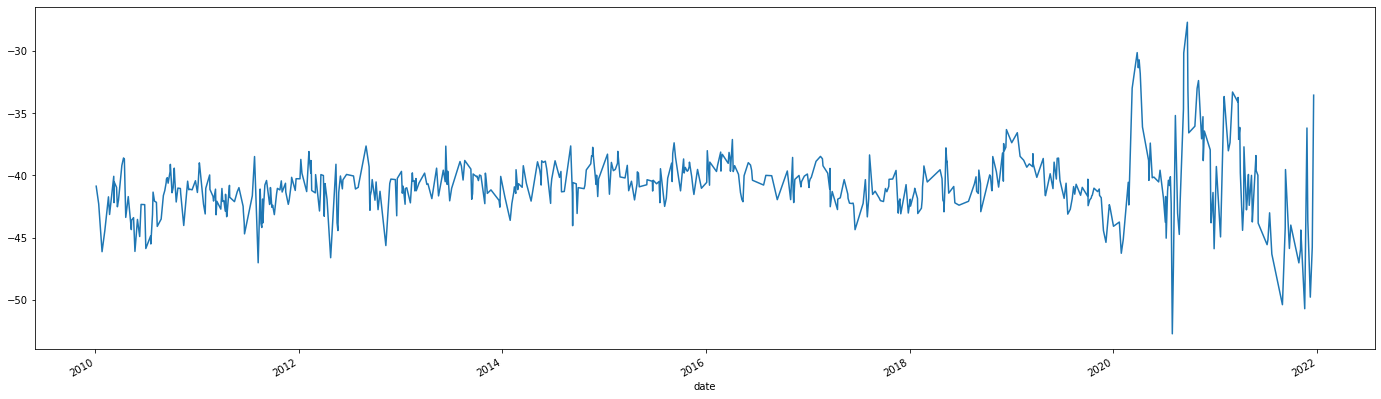

In [56]:
resids.plot(figsize = (24,7))